# **fellowship.ai Code Challenge Problem:** 102 Flower Classification

**Author:** Diya Baddipudi Prasad
- Solution to the Code Challenge Problem for applications to Cohort 32.

## Computer Vision (CV) Challenge:
Use a pre-trained ResNet 50 and train on the Flowers dataset.

- Conduct your analysis using a well-commented Jupyter notebook. Ensure you code is clear and well-documented to demonstrate your analytical approach.
- Upload your completed notebook to GitHub or Google Colab.


## Overview of the process

Based on Fast.ai's 'Practical Deep Learning For Coders' video series.

- Data Preprocessing: we extract the data and arrange it into a suitable format by sorting the images into different folders by labels
- Model Traning: Train the ResNet50 network on the sorted images
- Manual Validation: Validate the network's classification abilities by running it on some sample images from the original image data
- Use The Model: Use the model on the sample images and on images from the internet. 

## Step 1: Data Preprocessing

Extract the images and category labels from the downloaded files, and sort the images into folders based on which category they belong to.

Import the required packages.

In [1]:
# Package imports

from fastbook import search_images_ddg
from fastcore.all import *
from fastai.vision.all import *

Convert the .mat file data into a Pandas DataFrame.

In [2]:
# Load imagelabels.mat into a DataFrame
# -------
import pandas as pd
from scipy.io import loadmat

data_dict  = loadmat('./imagelabels.mat')
data_array = data_dict['labels']
data_array = data_array.transpose(1, 0)
imagelabels_df = pd.DataFrame(data_array, columns=['labels'])

# with pd.option_context('display.max_rows', None):
#     display(imagelabels_df['labels'])

Create a folder fot the sorted images, and inside it sub-directories for each category label (1, 2, 3, ..., 102).

In [3]:
# Create folders for each label
# -------
import os

# Create a directory for each label
for label in imagelabels_df['labels'].unique():
    os.makedirs(f'./sorted_images/{label}', exist_ok=True)

Create a DataFrame to associate each image with its label.

In [5]:
# Make a df column of image filenames
# -------

# Path to the folder containing unsorted images
# Extracted 102flowers.tgz > 'jpg' > renamed to 'unsorted_images'
unsorted_images_folder = './unsorted_images'

# Create a variable to store the sorted images folder's path
sorted_images_folder = './sorted_images'

# Extract image filenames and add them to imagelabels_df
image_filenames = sorted([f for f in os.listdir(unsorted_images_folder) if f.endswith('.jpg')])
imagelabels_df['filenames'] = image_filenames

# Sort by label values
grouped_image_labels = imagelabels_df.sort_values(by='labels', ascending=True)

# Reset the index after sorting
grouped_image_labels = grouped_image_labels.reset_index(drop=True)

Sort the images into folders corresponding to their labels. Uniformly resize them in the process.

In [6]:
# Move images into their corresponding folders

for index, row in grouped_image_labels.iterrows():
    image_name = row['filenames']
    label = row['labels']

    # Construct the source and destination paths
    label_folder = os.path.join(sorted_images_folder, str(label))

    src_path = os.path.join(unsorted_images_folder, 
                            image_name)
    dst_path = os.path.join(label_folder,
                            image_name)

    # Ensure the destination label folder exists
    os.makedirs(label_folder, exist_ok=True)
    
    # Open the image, resize, and save it to the destination
    with Image.open(src_path) as img:
        # Resize the image
        img.thumbnail((400, 400))  # Resize while maintaining aspect ratio
        img.save(dst_path)  # Save the resized image to the destination path

Count the files transferred to each folder. Compare this with images per label pre-sorting to ensure they match.

In [8]:
# Uncomment this line on MacOS to ensure that the subsequent lines run without issues
# !rm ./sorted_images/.DS_Store

# List label sub-directories containing the images 
folder_labels = sorted(os.listdir(sorted_images_folder), key=int)

# Create a folder to store the file counts for each sub-directory in
file_count = []

# Loop through each subfolder (label) in the parent folder
for folder in folder_labels:

    # Full path to subfolder
    subfolder_path = os.path.join(sorted_images_folder, folder)

    if os.path.isdir(subfolder_path):
        # Count the number of files in this subfolder
        file_count.append(len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]))

In [9]:
# Count the number of occurrences of each label
label_count = grouped_image_labels['labels'].value_counts().sort_index()

In [10]:
# Create a df of the counting data
count_compare = pd.DataFrame({
    'folder_labels' : folder_labels,
    'file_count'    : file_count,
    'label_count'   : label_count
})

if count_compare['file_count'].equals(count_compare['label_count']):
    print("Image Sorting Complete: Filename counts and folder item counts are equal.")

Image Sorting Complete: Filename counts and folder item counts are equal.


## Step 2: Model Training

Exclude incorrectly downloaded or corrupted images that may cause issues when training the model.

In [13]:
path = Path(sorted_images_folder)

failed = verify_images(get_image_files(path))
failed.map(path.unlink)   # Delete failed images from the directory
len(failed)     # Return number of failed images

0

Using the `DataBlock` object in the `fastai` library, we can create a DataLoaders object. It organises the images into batches

We split the data into training and validation sets by random selection using `RandomSplitter`. In this case, we're setting aside 20% of the data for the validation set.

The image files' parent folders' labels are set as the category labels in `CategoryBlock`. For uniformity across the data, we resize all the images by the same method.

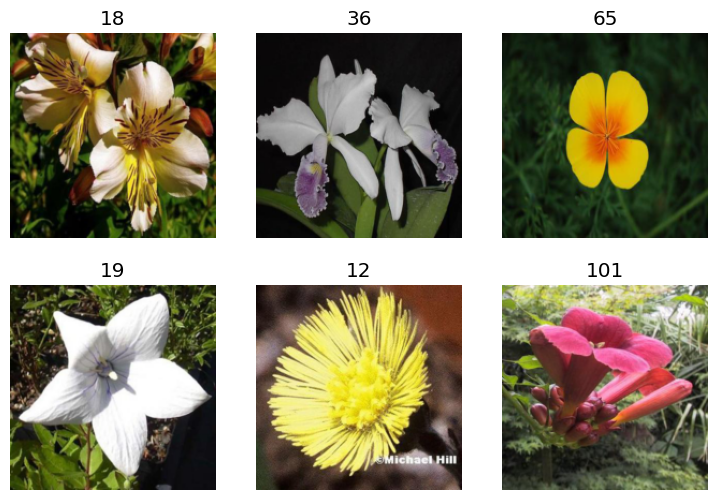

In [16]:
# Create a DataBlock from the sorted_images data
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')],
).dataloaders(path, bs=32)

# Displays batch of 6 images with their respective category labels.
dls.show_batch(max_n=6)

Fine-tune the model (a pre-trained ResNet50 network) on the dls `DataBlock` for 5 epochs. 

In [17]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.791724,0.778920,0.189982,01:28


epoch,train_loss,valid_loss,error_rate,time
0,0.486246,0.331986,0.081246,01:49
1,0.218270,0.255603,0.064753,01:49
2,0.080985,0.204798,0.054979,01:49
3,0.037936,0.186955,0.052535,01:51
4,0.024736,0.176023,0.043983,01:47


So now we have a model that is ~95% accurate.

## Step 3: Preparing test samples for manual validation 

Now that the model's been trained, we'd like to test whether it works. Choosing examples from the internet is not scalable past 2-3 test cases, since we still don't know the flower species to which each label (1, 2, 3, ..., 102) corresponds.

1. We'll use the images displayed on the Category Statistics webpage to test our model by extracting the image filenames from the HTML.

2. Then we'll map the labels to their respective flower categories so that when we run the model on any flower, we can map the label returned to the associated flower. 

- Part I: Data extraction from HTML
- Part II: Mapping images to labels and categories
- Part II: Test sample preparation

### Part I: Data extraction from HTML

Use the `requests` and `BeautifulSoup` libraries to extract the images and categories displayed on the Category Statistics page.

In [18]:
import requests
from bs4 import BeautifulSoup

# Link the category statistics page's url
url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html'

response = requests.get(url)
soup     = BeautifulSoup(response.content, 'html.parser')

We extract the flower category names to map to the numbered labels. For the manual validation data set, we'll extract the filenames of the images displayed on the website as representative thumbnails for each flower species.

In [19]:
# Filter all tags with the listed class labels
html_labels = soup.find_all('td', class_=['labL', 'labC', 'labR'])
html_images = soup.find_all('td', class_=['imL',  'imC',  'imR'])

# Extract the labels and image filenames from the tags
html_labels   = [i.get_text(strip=True) for i in html_labels]

# Format the image filenames to match the downloaded images' naming format
html_images   = [j.find('img')['src'] for j in html_images]
html_images   = ['image' + k.split('m')[-1] for k in html_images]

### Part II: Mapping images to labels and categories

Create a dictionary mapping the labels (1, 2, 3, ..., 102) to their corresponding flower categories.

In [20]:
# Create a dictionary to store 'image_name', 'flower_category' pairs for the test samples.
flower_dict = {}

for n in range(len(html_labels)):
    category   = html_labels[n]
    image_name = html_images[n]

    flower_dict[image_name] = category

flower_dict = {key: flower_dict[key] for key in sorted(flower_dict)}

flower_dict

{'image_00005.jpg': 'passion flower',
 'image_00323.jpg': 'water lily',
 'image_00590.jpg': 'cyclamen',
 'image_00634.jpg': 'watercress',
 'image_00784.jpg': 'frangipani',
 'image_00954.jpg': 'wallflower',
 'image_01270.jpg': 'rose',
 'image_01456.jpg': 'petunia',
 'image_01511.jpg': 'poinsettia',
 'image_01668.jpg': 'clematis',
 'image_01761.jpg': 'hibiscus',
 'image_01863.jpg': 'lotus',
 'image_02011.jpg': 'anthurium',
 'image_02144.jpg': 'thorn apple',
 'image_02211.jpg': 'barbeton daisy',
 'image_02392.jpg': 'sword lily',
 'image_02451.jpg': 'morning glory',
 'image_02577.jpg': 'columbine',
 'image_02747.jpg': 'geranium',
 'image_02779.jpg': 'bishop of llandaff',
 'image_02910.jpg': 'tree mallow',
 'image_02947.jpg': 'pink-yellow dahlia?',
 'image_03070.jpg': 'bee balm',
 'image_03117.jpg': 'snapdragon',
 'image_03206.jpg': 'californian poppy',
 'image_03291.jpg': 'bird of paradise',
 'image_03379.jpg': 'fritillary',
 'image_03495.jpg': 'sweet william',
 'image_03581.jpg': 'azalea'

Then create a dictionary mapping labels of the images on the site to their respective categories. This works because there is one example for each category.

In [21]:
grouped_image_labels = grouped_image_labels.set_index('filenames')
grouped_image_labels

,labels
filenames,
image_06767.jpg,1
image_06755.jpg,1
image_06756.jpg,1
image_06758.jpg,1
image_06759.jpg,1
...,...
image_08018.jpg,102
image_08019.jpg,102
image_08020.jpg,102


In [22]:
label_to_category = {}

for image in html_images:
    label = grouped_image_labels.loc[image, 'labels']
    label_to_category[label] = flower_dict[image]

In [23]:
# Sort the keys
sorted_keys = sorted(label_to_category.keys())

# New dictionary with the sorted keys
label_to_category = {key: label_to_category[key] for key in sorted_keys}

# Print the sorted dictionary
label_to_category

{1: 'pink primrose',
 2: 'hard-leaved pocket orchid',
 3: 'canterbury bells',
 4: 'sweet pea',
 5: 'english marigold',
 6: 'tiger lily',
 7: 'moon orchid',
 8: 'bird of paradise',
 9: 'monkshood',
 10: 'globe thistle',
 11: 'snapdragon',
 12: "colt's foot",
 13: 'king protea',
 14: 'spear thistle',
 15: 'yellow iris',
 16: 'globe-flower',
 17: 'purple coneflower',
 18: 'peruvian lily',
 19: 'balloon flower',
 20: 'giant white arum lily',
 21: 'fire lily',
 22: 'pincushion flower',
 23: 'fritillary',
 24: 'red ginger',
 25: 'grape hyacinth',
 26: 'corn poppy',
 27: 'prince of wales feathers',
 28: 'stemless gentian',
 29: 'artichoke',
 30: 'sweet william',
 31: 'carnation',
 32: 'garden phlox',
 33: 'love in the mist',
 34: 'mexican aster',
 35: 'alpine sea holly',
 36: 'ruby-lipped cattleya',
 37: 'cape flower',
 38: 'great masterwort',
 39: 'siam tulip',
 40: 'lenten rose',
 41: 'barbeton daisy',
 42: 'daffodil',
 43: 'sword lily',
 44: 'poinsettia',
 45: 'bolero deep blue',
 46: 'wal

Combine all this information into a single DataFrame. This lets us lookup the label and category for any image by using its filename as the row index.

In [24]:
grouped_image_labels['categories'] = [label_to_category[label] for label in grouped_image_labels['labels'].tolist()]
grouped_image_labels

,labels,categories
filenames,,
image_06767.jpg,1,pink primrose
image_06755.jpg,1,pink primrose
image_06756.jpg,1,pink primrose
image_06758.jpg,1,pink primrose
image_06759.jpg,1,pink primrose
...,...,...
image_08018.jpg,102,blackberry lily
image_08019.jpg,102,blackberry lily
image_08020.jpg,102,blackberry lily


### Part III: Test sample preparation

We rename the representative image filenames according to the naming convention in the downloaded images, and copy them into a folder called `test_samples`.

In [26]:
import random
import shutil

# Paths to the folders
src_dir = Path(sorted_images_folder)
dst_dir = Path('./test_samples')

# Ensure the destination directory exists
os.makedirs(dst_dir, exist_ok=True)

# Create ordered sample images list
sample_images_list = html_images

for image in sample_images_list:
    label = grouped_image_labels.loc[image, 'labels']
    image_path = os.path.join(src_dir, f'{label}', image)
    shutil.copy(image_path, dst_dir)

Now we have the test samples ready to use.

## Step 4: Using the model

### Part I: Classifying test samples from original images dataset.

We will manually validate the model's predictions using the test samples obtained from the previous step.

First we test it out for a single sample.


Actual (label, category): (74, rose)
Predicted (label, category): (74, rose)

Probability: 0.9999946355819702



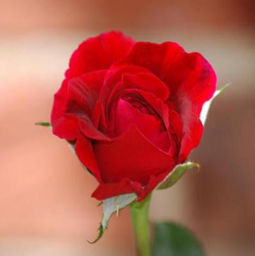

In [28]:
predicted_label,_,probs = learn.predict(PILImage.create(f'./test_samples/image_01270.jpg'))

print(f"""
Actual (label, category): ({grouped_image_labels.loc['image_01270.jpg', 'labels']}, {label_to_category[int(grouped_image_labels.loc['image_01270.jpg', 'labels'])]})
Predicted (label, category): ({predicted_label}, {label_to_category[int(predicted_label)]})

Probability: {probs.max()}
""")

Image.open(f'./test_samples/image_01270.jpg').to_thumb(256, 256)

Now that it works, we apply the model to all the test samples we isolated in the previous section.

In [38]:
# Actual labels, categories -- taken from the grouped_image_labels DataFrame
act_labs, act_cats   = [], []
pred_labs, pred_cats = [], []

# Probabilities of predicted results for each test sample
pred_results_probs = []

for image in sample_images_list:

    pred_label,_,probs = learn.predict(PILImage.create(f'./test_samples/{image}'))

    actual_label    = int(grouped_image_labels.loc[image, 'labels'])    # image label from grouped_image_labels
    actual_category = label_to_category[actual_label]                   # image category from grouped_image_labels

    act_labs.append(actual_label)
    act_cats.append(actual_category)

    pred_labs.append(int(pred_label))
    pred_cats.append(label_to_category[int(pred_label)])

    pred_results_probs.append(round(np.array(probs).max(), 4))  # Get maximum probability and round off to 4 decimal places

Organise all this information into a single DataFrame for easier viewing.

In [39]:
# Organise the test sample prediction information into a DataFrame
test_pred_df = pd.DataFrame({
    'sample_image' : sample_images_list,
    'predicted_label' : pred_labs,
    'actual_label' : act_labs,
    'predicted_category' : pred_cats,
    'actual_category' : act_cats,
    'prediction_probability' : pred_results_probs
})

test_pred_df = test_pred_df.set_index('sample_image')

# Display DataFrame sorted by increasing prediction probability
display(test_pred_df.sort_values(by='prediction_probability'))

,predicted_label,actual_label,predicted_category,actual_category,prediction_probability
sample_image,,,,,
image_06601.jpg,25,25,grape hyacinth,grape hyacinth,0.7604
image_03886.jpg,17,17,purple coneflower,purple coneflower,0.9465
image_06884.jpg,27,27,prince of wales feathers,prince of wales feathers,0.9769
image_02779.jpg,56,56,bishop of llandaff,bishop of llandaff,0.9950
image_04481.jpg,71,71,gazania,gazania,0.9952
...,...,...,...,...,...
image_02947.jpg,60,60,pink-yellow dahlia?,pink-yellow dahlia?,1.0000
image_07737.jpg,97,97,mallow,mallow,1.0000
image_01511.jpg,44,44,poinsettia,poinsettia,1.0000


To display the entire DataFrame, uncomment the code below.

In [40]:
# Display entire DataFrame
# with pd.option_context('display.max_rows', None):
#     display(test_pred_df.sort_values(by='prediction_probability'))

We'd like to know which images were incorrectly classified, so we compare the `predicted_category` and `actual_category` columns and extract mismatching values.

In [41]:
# Isolate images for which predictions are incorrect
pred_mismatches = test_pred_df[test_pred_df['predicted_category'] != test_pred_df['actual_category']].index.tolist()

test_pred_df.loc[pred_mismatches]

,predicted_label,actual_label,predicted_category,actual_category,prediction_probability
sample_image,,,,,


Ideally it would be informative to visually compare the actual image with one from the predicted category. However, some of the flower categories have much greater variation in image data than others. I wasnt't able to come up with a satisfactory way to find which image from an incorrect predicted category the actual image resembles, which I thought could somewhat explain incorrect classifications.

So for now I've just had it display the category names, the image of the actual flower, and a representative image of the predicted flower downloaded from the internet.

In [42]:
from fastdownload import download_url

# Display the incorrectly classified images
for image in pred_mismatches:

    # Define actual and predicted image as variables
    act_img  = f'./test_samples/{image}'                        # Path of actual image
    pred_img = test_pred_df.loc[image, 'predicted_category']    # Category label of predicted image

    # Download a sample of the predicted image
    download_url(search_images_ddg(f'{pred_img} single flower', 
                                   max_images=1)[0], 
                                   f'{pred_img}.jpg', 
                                   show_progress=False)

    # Print flower category and image for (actual, predicted)
    # ---
    print(f'Actual Flower:    {test_pred_df.loc[image, 'actual_category']}')
    display(Image.open(act_img)).to_thumb(256, 256)

    print(f'Predicted Flower: {test_pred_df.loc[image, 'predicted_category']}')
    display(Image.open(f'{pred_img}.jpg')).to_thumb(256, 256)

### Part II: Classifying images from the internet

We'll apply the model to images taken from the internet and see how effective it is for a few examples.

Let's randomly choose 3 flower categories, and download images of them from the internet. First choose the categories:

In [85]:
# Choose 3 random flower categories
label_sample = random.sample(list(np.arange(1, 103)), k=3)
flower_sample = [label_to_category[label] for label in label_sample]

label_sample, flower_sample

([58, 14, 44], ['geranium', 'spear thistle', 'poinsettia'])

In [86]:
flower_sample = [[i, ''.join(f'{i}'.title().replace('-', ' ').split())] for i in flower_sample]

In [87]:
flower_sample

[['geranium', 'Geranium'],
 ['spear thistle', 'SpearThistle'],
 ['poinsettia', 'Poinsettia']]

Then download one image per category and save them accordingly. Sometimes this code block runs into HTTPError errors -- I just try re-running it a few times, or choose a different set of 3 flowers to test the model on.

geranium


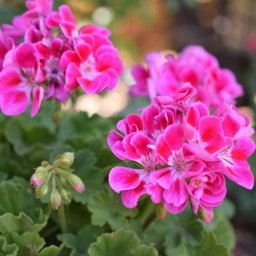

spear thistle


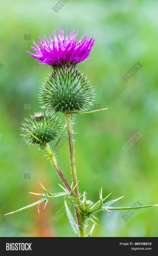

poinsettia


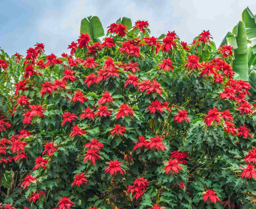

In [92]:
for flower_name in flower_sample:
    download_url(search_images_ddg(f'{flower_name[0]} single flower', 
                                   max_images=1)[0], 
                                   f'{flower_name[1]}.jpg', 
                                   show_progress=False)
    
    print(flower_name[0])
    display(Image.open(f'{flower_name[1]}.jpg').to_thumb(256, 256))

Once the images from above are successfully downloaded, run the model on each image by iterating through the `flower_sample` list.

In [93]:
for flower_name in flower_sample:
    pred_label,_,probs = learn.predict(PILImage.create(f'{flower_name[1]}.jpg'))

    print(f'''
Flower name:    {flower_name[0]}
Predicted name: {label_to_category[int(pred_label)]}, {pred_label}
Probability:    {round(np.array(probs).max(), 4)}
''')


Flower name:    geranium
Predicted name: garden phlox, 32
Probability:    0.6431999802589417




Flower name:    spear thistle
Predicted name: spear thistle, 14
Probability:    1.0




Flower name:    poinsettia
Predicted name: prince of wales feathers, 27
Probability:    0.35670000314712524



## Observations

The model seems to fail or have a lower probabilty when:
- multiple flowers (even of the same species) are in the frame
- when two or more flower categories share similar colours or overall shape

Possible causes:
- Small sample size per category
- Most images in most categories contain 1-5 flowers in the frame
- Inadequate training epochs?

One idea that seems interesting is to use PCA to find clusers of similar flowers from a scatter plot to predict which species the model may find hard to distinguish between. I'll explore this further.

**Note:** For probabilities, I've used the maximum value of each tensor as the prediction probability because in trial runs with smaller datasets the index of the maximum value and that corresponding to the image's category label (1-102) correspond. However, since this might not always be the case, this is probably not the best way to determine the prediction probability.   